## Mushroom 다중분류 모델 만들기<hr>
- 데이터셋 : feature(kaggle의 mushroom img data) + target(수제 독판별 csv)
- 데이터수 : 총 3122개 이미지(학습용 2500, 테스트 400, 검증 222)
- 피쳐갯수 : 512 X 512(X3) 컬러이미지로 786432
- 타겟갯수 : 0(식용버섯), 1(비식용버섯), 2(독버섯) 3가지

### [1] 모듈 로딩 및 데이터 준비

In [1]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image

from torch.utils.data import Dataset, DataLoader, random_split

In [38]:
# 타겟이 될 csv 로딩
name = pd.read_csv('mushrooms2.csv',header=None)
name

,0,1
0,almond_mushroom,0
1,amanita_gemmata,2
2,amethyst_chanterelle,0
3,amethyst_deceiver,0
4,aniseed_funnel,0
...,...,...
210,yellow_false_truffle,1
211,yellow_foot_waxcap,0
212,yellow_stagshorn,1
213,yellow_stainer,2


In [39]:
name[0]

0               almond_mushroom
1               amanita_gemmata
2          amethyst_chanterelle
3             amethyst_deceiver
4                aniseed_funnel
                 ...           
210        yellow_false_truffle
211          yellow_foot_waxcap
212            yellow_stagshorn
213              yellow_stainer
214    yellow_swamp_brittlegill
Name: 0, Length: 215, dtype: object

In [40]:
m_list = ['edible', 'inedible', 'poisonous']

In [41]:
name_List=list(name[0])
name_List

['almond_mushroom',
 'amanita_gemmata',
 'amethyst_chanterelle',
 'amethyst_deceiver',
 'aniseed_funnel',
 'ascot_hat',
 'bay_bolete',
 'bearded_milkcap',
 'beechwood_sickener',
 'beefsteak_fungus',
 'birch_polypore',
 'birch_woodwart',
 'bitter_beech_bolete',
 'bitter_bolete',
 'black_bulgar',
 'black_morel',
 'blackening_brittlegill',
 'blackening_polypore',
 'blackening_waxcap',
 'blue_roundhead',
 'blushing_bracket',
 'blushing_rosette',
 'blushing_wood_mushroom',
 'bovine_bolete',
 'bronze_bolete',
 'brown_birch_bolete',
 'brown_rollrim',
 'bruising_webcap',
 'butter_cap',
 'cauliflower_fungus',
 'cedarwood_waxcap',
 'chanterelle',
 'charcoal_burner',
 'chestnut_bolete',
 'chicken_of_the_woods',
 'cinnamon_bracket',
 'clouded_agaric',
 'clustered_domecap',
 'common_bonnet',
 'common_inkcap',
 'common_morel',
 'common_puffball',
 'common_rustgill',
 'crimped_gill',
 'crimson_waxcap',
 'cucumber_cap',
 'curry_milkcap',
 'deadly_fibrecap',
 'deadly_webcap',
 'deathcap',
 'deer_shield

In [42]:
folder_path = './mushroom2'
all_mushrooms = []
for names in name_List:
    folder_path = './mushroom2'
    folder_path = os.path.join(folder_path, names)
    
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    print(image_files[3],image_files[-1])
    all_mushrooms.append(image_files)

print(len(all_mushrooms))

11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
2.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
3.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
3.png 8.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
3.png 7.png
11.png 9.png
11.png 9.png
11.png 9.png
3.png 7.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.png 9.png
11.p

In [43]:
len(all_mushrooms)

215

In [44]:
name.shape

(215, 2)

In [45]:
# 타겟 설정 : 버섯 분류 (0: 식용가능, 1: 식용불가, 2:독버섯)
target_list = []
for i in range(215):
    if name.iloc[i][1] == 0:
        for j in range(len(all_mushrooms[i])):
            target_list.append(0)
    elif name.iloc[i][1] == 1:
        for j in range(len(all_mushrooms[i])):
            target_list.append(1)
    elif name.iloc[i][1] == 2:
        for j in range(len(all_mushrooms[i])):
            target_list.append(2)
        
print(len(target_list))
target = np.array(target_list)
target.shape

3122


(3122,)

In [46]:
feature_list = []
for i in range(len(all_mushrooms)):
    for j in all_mushrooms[i]:
        # 모든 이미지파일 이름 지정 완료
        folder_path = os.path.join('./mushroom2',name_List[i])
        file_name = os.path.join(folder_path,j)
        # openCV 는 BGR타입으로 읽어옴
        img_bgr = cv2.imread(file_name, cv2.IMREAD_COLOR)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        
        # 이미지가 너무 커서 이미지 축소 필요
        img = cv2.resize(img_rgb, (150,150))
        feature_list.append(img)
    
feature = np.array(feature_list)
feature.shape

(3122, 150, 150, 3)

In [47]:
# color라 4차원 데이터
print(f'feature => {type(feature)}, {feature.shape}')
print(f'feature raw data =>\n{feature[:1]}\n')

print(f'target  => {type(target)},{target.shape}')
print(f'target raw data  => {target[:1]}')

feature => <class 'numpy.ndarray'>, (3122, 150, 150, 3)
feature raw data =>
[[[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  ...

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]]]

target  => <class 'numpy.ndarray'>,(3122,)
target raw data  => [0]


In [48]:
feature_ = feature.reshape(feature.shape[0], -1)
feature_.shape

(3122, 67500)

In [49]:
### 혹시 모르니 feature csv로 저장..
# 8억 픽셀이다... 저장하자
# np.savetxt('mushroom_img.csv',feature_,delimiter=',')

In [50]:
# 만일 날아갈 경우를 대비하여 불러오기
# img_df = pd.read_csv('mushroom_img.csv')
# feature_ = img_df.values

In [51]:
folder_path = os.path.join('./mushroom2',name_List[0])
file_name = os.path.join(folder_path,'0.png')
print(file_name)
img = cv2.imread(file_name, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (150,150))

# 점의 가운데를 더 선명하게 만드는 커널
kernel = np.array([[0,-1,0],
                   [-1,5,-1],
                   [0,-1,0]])
img_sharp = cv2.filter2D(img, -1, kernel)
print(img.shape)

./mushroom2\almond_mushroom\0.png
(150, 150, 3)


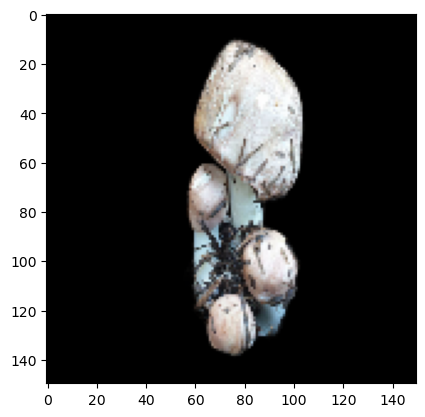

In [52]:
plt.imshow(img)

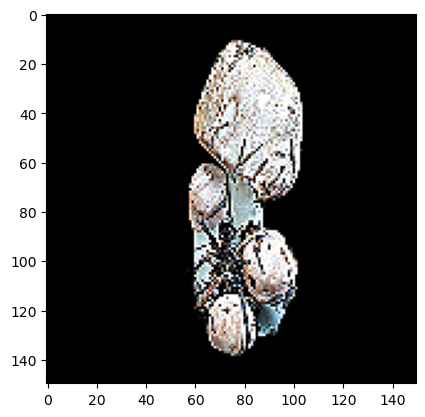

In [53]:
plt.imshow(img_sharp)   # 별로다

In [54]:
target.dtype

dtype('int32')

In [55]:
# 피쳐 정규화
norm_feature = feature_/255.

print(f'norm_feature min => {norm_feature.min()}    max => {norm_feature.max()}')

norm_feature min => 0.0    max => 1.0


In [56]:
# 타겟은 타입 그대로라 괜찮다
# 0,1,2 정수 로 반환
print(target.dtype)

int32


### [3] 학습 데이터셋 준비 - 훈련용, 검증용, 테스트용 데이터 셋

[3-1] 전체 데이터셋 준비

In [57]:
## 데이터셋 클래스 생성
class DLDataset(Dataset):
    
    def __init__(self, x_data, y_data):
        super().__init__()
        # ndarray 를 tensor 로 변경
        self.feature=torch.FloatTensor(x_data)
        self.target=torch.LongTensor(y_data)
    
    def __len__(self):
        return self.target.shape[0]
    
    def __getitem__(self, idx):
        return self.feature[idx], self.target[idx]

In [58]:
# 전체 데이터셋 생성
all_dataset = DLDataset(norm_feature,target)

print(f'[all dataset] feature : {all_dataset.feature.shape},'
      f'target : {all_dataset.target.shape}')

[all dataset] feature : torch.Size([3122, 67500]),target : torch.Size([3122])


[3-2] 학습용, 검증용, 테스트용 데이터셋 분리

In [59]:
# 랜덤 설정 : random_split
seed_gen = torch.Generator().manual_seed(17)

trainDS, testDS, validDS = random_split(all_dataset, 
                                        [2500,400,222], generator=seed_gen)

print(f"Train dataset length : {len(trainDS)}개")
print(f"Test dataset         : {len(testDS)}개")
print(f"Validation dataset   : {len(validDS)}개")

Train dataset length : 2500개
Test dataset         : 400개
Validation dataset   : 222개


[3-3] 데이터 로더 생성

In [60]:
BATCH_SIZE = 10

TRAIN_DL = DataLoader(trainDS, batch_size=BATCH_SIZE, shuffle=True)
TEST_DL = DataLoader(testDS, batch_size=BATCH_SIZE, shuffle=True)
VALID_DL = DataLoader(validDS, batch_size=BATCH_SIZE, shuffle=True)

### [4] 학습 모델 준비

In [61]:
### 다중 분류 모델
### 입력층 피쳐 수 : 150 * 150 = 67500
### 출력층 피쳐 수 : 3 (0 ~ 2)
class MUSHROOMModel(nn.Module):
    
    # 모델 구성요소
    def __init__(self, in_dim, out_dim, hidden_dim):
        super().__init__()
        self.layer1 = nn.Linear(in_dim, hidden_dim[0])
        # 은닉충을 자유롭게 설정가능하도록 
        self.layer_List = nn.ModuleList([])
        if len(hidden_dim) > 1:
            for a in range(len(hidden_dim)-1):
                self.layer_h = nn.Linear(hidden_dim[a], hidden_dim[a+1])
                self.layer_List.append(self.layer_h)
        self.layer2 = nn.Linear(hidden_dim[-1], out_dim)
        # 활성화 함수 relu
        self.relu = nn.ReLU()
    
    def forward(self, x):
        y = self.relu(self.layer1(x))
        for layer in self.layer_List:
            y = self.relu(layer(y))
        y = self.layer2(y)
        return y
    

[5] 학습 함수 준비 : 디바이스, 모델, 최적화, 손실함수, 학습횟수, 학습함수, 예측함수

In [62]:
# 실행 디바이스
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [63]:
# 모델
IN, OUT = norm_feature.shape[1], np.unique(target).size

# 은닉층은 일단 3단계로
HIDDEN_DIM = [150, 15]

# 모델 생성
model = MUSHROOMModel(IN, OUT, HIDDEN_DIM).to(DEVICE)
model2 = MUSHROOMModel(IN, OUT, [500]).to(DEVICE)

In [64]:
model.parameters()

<generator object Module.parameters at 0x0000015DC5BFA120>

In [65]:
# 최적화 인스턴스 생성
OPTIMIZER = optim.Adam(model.parameters(), lr=0.01)

In [66]:
# 손실함수 인스턴스 생성 (다중분류)
LOSS_FN = nn.CrossEntropyLoss().to(DEVICE)

In [67]:
# 학습횟수(Epoch)
EPOCHS = 20

[5-2] 학습 진행 함수 생성

In [68]:
import torchmetrics.functional as metrics

In [90]:
## 학습 진행함수 training()
def training(epoch):
    # 학습모드 : 정규화, 경사하강법, drop out 기능 활성화
    model.train()
    
    # 배치크기 만큼 학습 진행, 저장
    # 순서대로 loss, accuracy, recall, precision, f1_score 저장
    train_report=[[],[],[],[],[]]
    for idx, (feature, target) in enumerate(TRAIN_DL):
        feature, target = feature.to(DEVICE), target.to(DEVICE)
        
        # 학습
        pre_target = model(feature)
        
        # loss(손실) 계산
        loss = LOSS_FN(pre_target, target)
        train_report[0].append(loss)
        
        # 성능 평가(acc, recall, precision, f1)
        acc = metrics.accuracy(pre_target, target, task='multiclass', num_classes=3)
        train_report[1].append(acc)
        
        recall = metrics.recall(pre_target, target, task='multiclass', num_classes=3)
        train_report[2].append(recall)
        
        prec = metrics.precision(pre_target, target, task='multiclass', num_classes=3)
        train_report[3].append(prec)
        
        f1 = metrics.f1_score(pre_target, target, task='multiclass', num_classes=3)
        train_report[4].append(f1)
        
        # w, b 업데이트
        OPTIMIZER.zero_grad()   # 초기화
        loss.backward()
        OPTIMIZER.step()
        
        if not idx%50: print('.', end='')
    
    
    # 에포크 단위 진행 메세지 출력
    loss_score = (sum(train_report[0])/len(train_report[0])).item()
    acc_score = (sum(train_report[1])/len(train_report[0])).item()
    recall_score = (sum(train_report[2])/len(train_report[0])).item()
    prec_score = (sum(train_report[3])/len(train_report[0])).item()
    f1_score = (sum(train_report[4])/len(train_report[0])).item() 
    print(f'\n[{epoch+1} Train ]\t Loss ==> {loss_score}\t Acc ==> {acc_score}\n'
          f'\t\trecall ==> {recall_score}\t prec ==> {prec_score}\t F1 ==> {f1_score}')
    
    return loss_score, acc_score, recall_score, prec_score, f1_score
    

In [91]:
## 검증 및 테스트 진행함수
def testing(epoch, kind='valid'):
    # 추론 모드 => 정규화, 경사하강법, 드랍아웃 기능 비활성
    model.eval()
    
    # 경사하강 스톱
    with torch.no_grad():
        test_report=[[],[],[],[],[]]
        for idx, (feature, target) in enumerate(VALID_DL if kind == 'valid' else TEST_DL):
            feature, target = feature.to(DEVICE), target.to(DEVICE)
            
            # 학습
            pre_target = model(feature)
            
            # loss(손실) 계산
            loss = LOSS_FN(pre_target, target)
            test_report[0].append(loss)
            
            # 성능 평가(acc, recall, precision, f1)
            acc = metrics.accuracy(pre_target, target, task='multiclass', num_classes=3)
            test_report[1].append(acc)
            
            recall = metrics.recall(pre_target, target, task='multiclass', num_classes=3)
            test_report[2].append(recall)
            
            prec = metrics.precision(pre_target, target, task='multiclass', num_classes=3)
            test_report[3].append(prec)
            
            f1 = metrics.f1_score(pre_target, target, task='multiclass', num_classes=3)
            test_report[4].append(f1)
            
    
    
    testing_type = 'Valid' if kind == 'valid' else 'Test'
    
    # 에포크 단위 학습 진행 메세지 출력
    loss_score = (sum(test_report[0])/len(test_report[0])).item()
    acc_score = (sum(test_report[1])/len(test_report[0])).item()
    recall_score = (sum(test_report[2])/len(test_report[0])).item()
    prec_score = (sum(test_report[3])/len(test_report[0])).item()
    f1_score = (sum(test_report[4])/len(test_report[0])).item() 
    print(f'\n[{epoch+1} {testing_type} ]\t Loss ==> {loss_score}\t Acc ==> {acc_score}\n'
          f'\t\t\trecall ==> {recall_score}\t prec ==> {prec_score}\t F1 ==> {f1_score}')
    
    return loss_score, acc_score, recall_score, prec_score, f1_score

In [71]:
## 학습 중 모델 저장 관련 변수
dir = '../HW'
filename = 'new_mushroom_model.pth'

if not os.path.exists(dir): os.mkdir(dir)

### [6] 학습 시작

In [72]:
# 학습 및 검증 데이터별 성능지표 값
train_ = {'loss':[], 'acc':[], 'recall':[], 'prec':[], 'f1':[]}
val_ = {'loss':[], 'acc':[], 'recall':[], 'prec':[], 'f1':[]}

# 모델 저장 관련 변수
pre_va_recall_score = 0

# 학습 진행
for epo in range(EPOCHS):
    print(f'[Eoch {epo+1}/{EPOCHS}]', end='')   # 점이 입력되며 진행되게
    
    # 학습
    train_score = training(epo)
    # 검증
    val_score = testing(epo,'valid')
    
    # 검증 데이터 기준 loss가 이전보다 작아진 경우 저장되도록
    if pre_va_recall_score <= val_score[2]:
        print('SAVED\n')
        torch.save(model, filename)
        model.state_dict()
        pre_va_recall_score = val_score[2]
    # recall 점수가 떨어지면
    # elif pre_va_recall_score > val_score[2]:
    #     break
    
    # 각 학습, 검증별로 나온 score 저장
    for index, key in enumerate(train_):
        train_[key].append(train_score[index])
        val_[key].append(val_score[index])
print('finish')

[Eoch 1/20].....
[1 Train ]	 Loss ==> 1.46	 Acc ==> 0.55
		recall ==> 0.55	 prec ==> 0.55	 F1 ==> 0.55

[1 Valid ]	 Loss ==> 0.91	 Acc ==> 0.63
			recall ==> 0.63	 prec ==> 0.63	 F1 ==> 0.63
SAVED
[Eoch 2/20].....
[2 Train ]	 Loss ==> 0.95	 Acc ==> 0.61
		recall ==> 0.61	 prec ==> 0.61	 F1 ==> 0.61

[2 Valid ]	 Loss ==> 0.94	 Acc ==> 0.61
			recall ==> 0.61	 prec ==> 0.61	 F1 ==> 0.61
[Eoch 3/20].....
[3 Train ]	 Loss ==> 0.94	 Acc ==> 0.61
		recall ==> 0.61	 prec ==> 0.61	 F1 ==> 0.61

[3 Valid ]	 Loss ==> 0.96	 Acc ==> 0.60
			recall ==> 0.60	 prec ==> 0.60	 F1 ==> 0.60
[Eoch 4/20].....
[4 Train ]	 Loss ==> 0.94	 Acc ==> 0.61
		recall ==> 0.61	 prec ==> 0.61	 F1 ==> 0.61

[4 Valid ]	 Loss ==> 0.93	 Acc ==> 0.61
			recall ==> 0.61	 prec ==> 0.61	 F1 ==> 0.61
[Eoch 5/20].....
[5 Train ]	 Loss ==> 0.94	 Acc ==> 0.61
		recall ==> 0.61	 prec ==> 0.61	 F1 ==> 0.61

[5 Valid ]	 Loss ==> 0.93	 Acc ==> 0.61
			recall ==> 0.61	 prec ==> 0.61	 F1 ==> 0.61
[Eoch 6/20].....
[6 Train ]	 Loss ==> 0

### [7] 검증자료 비교

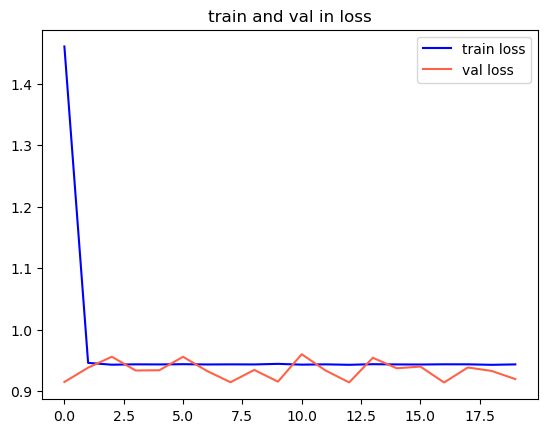

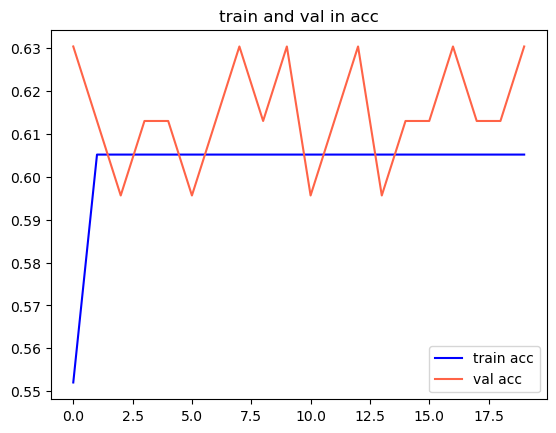

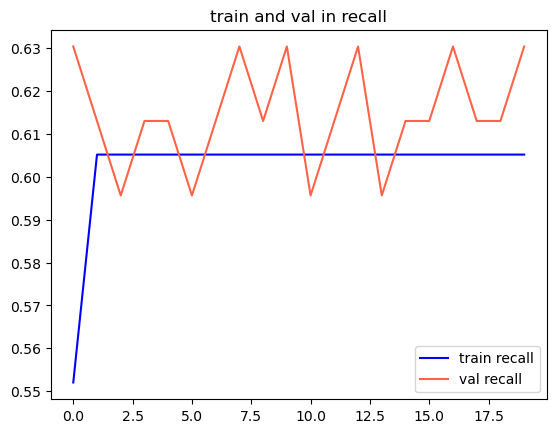

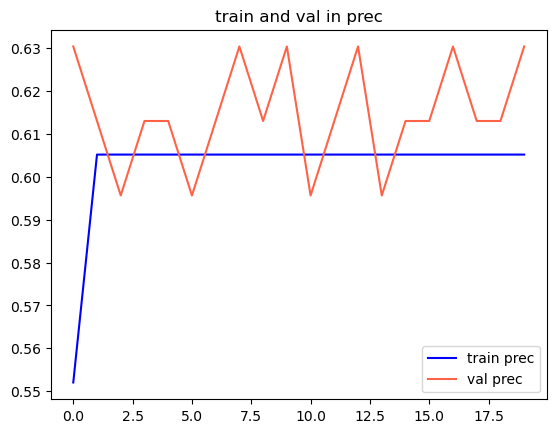

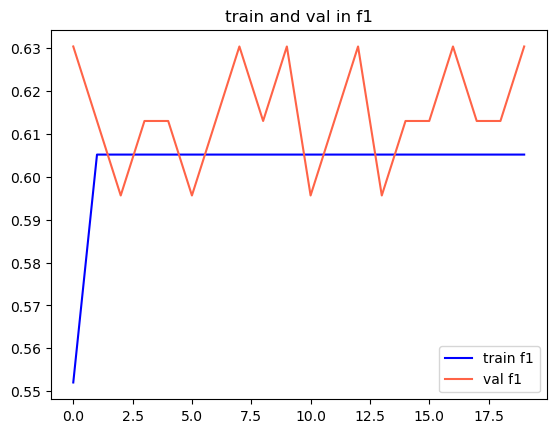

In [73]:
list1 = list(train_.keys())
for i in list1:
    plt.plot(train_[i], color='b',label='train '+i)
    plt.plot(val_[i], color='tomato',label='val '+i)
    plt.title('train and val in '+i)
    plt.legend()
    plt.show()

### [8] predict 될라나

In [74]:
for a in range(EPOCHS):
    testing(a,'test')


[1 Test ]	 Loss ==> 0.98	 Acc ==> 0.57
			recall ==> 0.57	 prec ==> 0.57	 F1 ==> 0.57

[2 Test ]	 Loss ==> 0.98	 Acc ==> 0.57
			recall ==> 0.57	 prec ==> 0.57	 F1 ==> 0.57

[3 Test ]	 Loss ==> 0.98	 Acc ==> 0.57
			recall ==> 0.57	 prec ==> 0.57	 F1 ==> 0.57

[4 Test ]	 Loss ==> 0.98	 Acc ==> 0.57
			recall ==> 0.57	 prec ==> 0.57	 F1 ==> 0.57

[5 Test ]	 Loss ==> 0.98	 Acc ==> 0.57
			recall ==> 0.57	 prec ==> 0.57	 F1 ==> 0.57

[6 Test ]	 Loss ==> 0.98	 Acc ==> 0.57
			recall ==> 0.57	 prec ==> 0.57	 F1 ==> 0.57

[7 Test ]	 Loss ==> 0.98	 Acc ==> 0.57
			recall ==> 0.57	 prec ==> 0.57	 F1 ==> 0.57

[8 Test ]	 Loss ==> 0.98	 Acc ==> 0.57
			recall ==> 0.57	 prec ==> 0.57	 F1 ==> 0.57

[9 Test ]	 Loss ==> 0.98	 Acc ==> 0.57
			recall ==> 0.57	 prec ==> 0.57	 F1 ==> 0.57

[10 Test ]	 Loss ==> 0.98	 Acc ==> 0.57
			recall ==> 0.57	 prec ==> 0.57	 F1 ==> 0.57

[11 Test ]	 Loss ==> 0.98	 Acc ==> 0.57
			recall ==> 0.57	 prec ==> 0.57	 F1 ==> 0.57

[12 Test ]	 Loss ==> 0.98	 Acc ==> 0.57


In [75]:
model_file = 'mushroom_model.pth'
mushroom_model = torch.load(model_file)
mushroom_model.eval()

print(mushroom_model)

MUSHROOMModel(
  (layer1): Linear(in_features=67500, out_features=2250, bias=True)
  (layer_List): ModuleList(
    (0): Linear(in_features=2250, out_features=150, bias=True)
    (1): Linear(in_features=150, out_features=15, bias=True)
  )
  (layer_h): Linear(in_features=150, out_features=15, bias=True)
  (layer2): Linear(in_features=15, out_features=3, bias=True)
  (relu): ReLU()
)


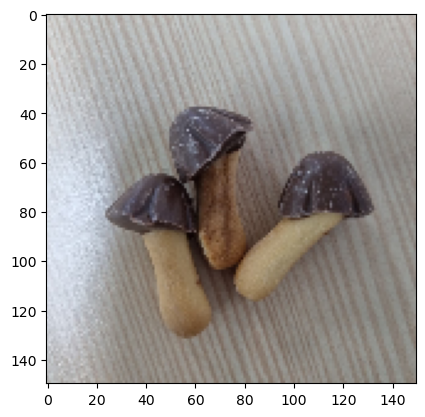

In [76]:
# 직접 찍은 사진으로 검사
file_name = 'test1.jpg'
# file_name = input('사진이름을 입력하세요: ')


img1 = cv2.imread(file_name, cv2.IMREAD_COLOR)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1 = cv2.resize(img1, (150,150))

plt.imshow(img1)

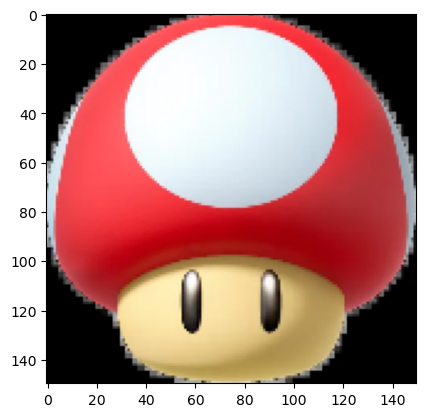

In [77]:
file_name = 'test2.jpg'
# file_name = input('사진이름을 입력하세요: ')


img2 = cv2.imread(file_name, cv2.IMREAD_COLOR)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2 = cv2.resize(img2, (150,150))

plt.imshow(img2)

In [78]:
feature_img1=img1.reshape(-1)
feature_img2=img2.reshape(-1)

In [79]:
# 정규화
norm_img1=feature_img1/255.
norm_img2=feature_img2/255.

In [80]:
input_img1 = torch.FloatTensor(norm_img1)
input_img2 = torch.FloatTensor(norm_img2)

print(model(input_img1),model(input_img2))

tensor([ 0.6787, -0.2541, -0.4094], grad_fn=<ViewBackward0>) tensor([ 0.6787, -0.2541, -0.4094], grad_fn=<ViewBackward0>)


In [81]:
print(m_list[model(input_img1).argmax()])
print(m_list[model(input_img2).argmax()])

edible
edible


In [82]:
def classify_img(model, file_name):
    img = cv2.imread(file_name, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (150,150))
    
    plt.imshow(img)
    
    feature_img=img.reshape(-1)
    norm_img=feature_img/255.
    
    input_img = torch.FloatTensor(norm_img)
    
    print(m_list[model(input_img).argmax()])

edible


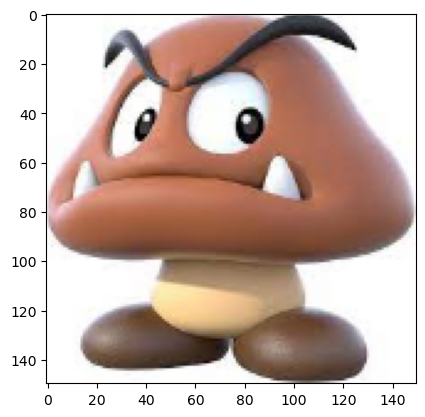

In [83]:
jpg_name = input('사진 이름을 입력하세요: ')
classify_img(model, jpg_name)

edible


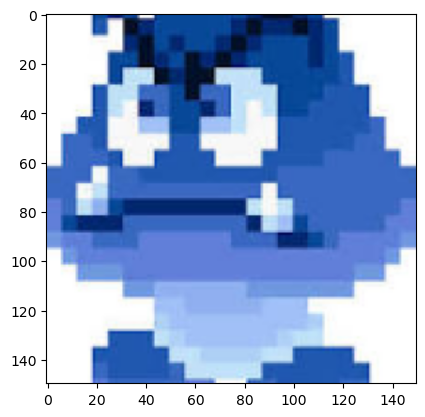

In [84]:
classify_img(model, 'test4.jpg')

In [85]:
## 학습 진행함수 training()
def training2(epoch):
    # 학습모드 : 정규화, 경사하강법, drop out 기능 활성화
    model2.train()
    
    # 배치크기 만큼 학습 진행, 저장
    # 순서대로 loss, accuracy, recall, precision, f1_score 저장
    train_report=[[],[],[],[],[]]
    for idx, (feature, target) in enumerate(TRAIN_DL):
        feature, target = feature.to(DEVICE), target.to(DEVICE)
        
        # 학습
        pre_target = model(feature)
        
        # loss(손실) 계산
        loss = LOSS_FN(pre_target, target)
        train_report[0].append(loss)
        
        # 성능 평가(acc, recall, precision, f1)
        acc = metrics.accuracy(pre_target, target, task='multiclass', num_classes=3)
        train_report[1].append(acc)
        
        recall = metrics.recall(pre_target, target, task='multiclass', num_classes=3)
        train_report[2].append(recall)
        
        prec = metrics.precision(pre_target, target, task='multiclass', num_classes=3)
        train_report[3].append(prec)
        
        f1 = metrics.f1_score(pre_target, target, task='multiclass', num_classes=3)
        train_report[4].append(f1)
        
        # w, b 업데이트
        OPTIMIZER.zero_grad()   # 초기화
        loss.backward()
        OPTIMIZER.step()
        
        if not idx%50: print('.', end='')
    
    
    # 에포크 단위 진행 메세지 출력
    loss_score = (sum(train_report[0])/len(train_report[0])).item()
    acc_score = (sum(train_report[1])/len(train_report[0])).item()
    recall_score = (sum(train_report[2])/len(train_report[0])).item()
    prec_score = (sum(train_report[3])/len(train_report[0])).item()
    f1_score = (sum(train_report[4])/len(train_report[0])).item() 
    print(f'\n[{epoch+1} Train ]\t Loss ==> {loss_score}\t Acc ==> {acc_score}\n'
          f'\t\trecall ==> {recall_score}\t prec ==> {prec_score}\t F1 ==> {f1_score}')
    
    return loss_score, acc_score, recall_score, prec_score, f1_score
    

In [86]:
## 검증 및 테스트 진행함수
def testing(epoch, kind='valid'):
    # 추론 모드 => 정규화, 경사하강법, 드랍아웃 기능 비활성
    model2.eval()
    
    # 경사하강 스톱
    with torch.no_grad():
        test_report=[[],[],[],[],[]]
        for idx, (feature, target) in enumerate(VALID_DL if kind == 'valid' else TEST_DL):
            feature, target = feature.to(DEVICE), target.to(DEVICE)
            
            # 학습
            pre_target = model(feature)
            
            # loss(손실) 계산
            loss = LOSS_FN(pre_target, target)
            test_report[0].append(loss)
            
            # 성능 평가(acc, recall, precision, f1)
            acc = metrics.accuracy(pre_target, target, task='multiclass', num_classes=3)
            test_report[1].append(acc)
            
            recall = metrics.recall(pre_target, target, task='multiclass', num_classes=3)
            test_report[2].append(recall)
            
            prec = metrics.precision(pre_target, target, task='multiclass', num_classes=3)
            test_report[3].append(prec)
            
            f1 = metrics.f1_score(pre_target, target, task='multiclass', num_classes=3)
            test_report[4].append(f1)
            
    
    
    testing_type = 'Valid' if kind == 'valid' else 'Test'
    
    # 에포크 단위 학습 진행 메세지 출력
    loss_score = (sum(test_report[0])/len(test_report[0])).item()
    acc_score = (sum(test_report[1])/len(test_report[0])).item()
    recall_score = (sum(test_report[2])/len(test_report[0])).item()
    prec_score = (sum(test_report[3])/len(test_report[0])).item()
    f1_score = (sum(test_report[4])/len(test_report[0])).item() 
    print(f'\n[{epoch+1} {testing_type} ]\t Loss ==> {loss_score:.2f}\t Acc ==> {acc_score:.2f}\n'
          f'\t\t\trecall ==> {recall_score:.2f}\t prec ==> {prec_score:.2f}\t F1 ==> {f1_score:.2f}')
    
    return loss_score, acc_score, recall_score, prec_score, f1_score

In [87]:
# 학습 및 검증 데이터별 성능지표 값
train_2 = {'loss':[], 'acc':[], 'recall':[], 'prec':[], 'f1':[]}
val_2 = {'loss':[], 'acc':[], 'recall':[], 'prec':[], 'f1':[]}

# 모델 저장 관련 변수
pre_va_loss_score = 30

# 학습 진행
for epo in range(EPOCHS):
    print(f'[Eoch {epo+1}/{EPOCHS}]', end='')   # 점이 입력되며 진행되게
    
    # 학습
    train_score = training(epo)
    # 검증
    val_score = testing(epo,'valid')
    
    # 검증 데이터 기준 loss가 이전보다 작아진 경우 저장되도록
    if pre_va_loss_score > val_score[0]:
        print('SAVED')
        torch.save(model, 'mushroom_model3.pth')
        model2.state_dict()
        pre_va_loss_score = val_score[0]
    
    # 각 학습, 검증별로 나온 score 저장
    for index, key in enumerate(train_):
        train_2[key].append(train_score[index])
        val_2[key].append(val_score[index])
print('finish')

[Eoch 1/20].....
[1 Train ]	 Loss ==> 0.94	 Acc ==> 0.61
		recall ==> 0.61	 prec ==> 0.61	 F1 ==> 0.61

[1 Valid ]	 Loss ==> 0.91	 Acc ==> 0.63
			recall ==> 0.63	 prec ==> 0.63	 F1 ==> 0.63
SAVED
[Eoch 2/20].....
[2 Train ]	 Loss ==> 0.94	 Acc ==> 0.61
		recall ==> 0.61	 prec ==> 0.61	 F1 ==> 0.61

[2 Valid ]	 Loss ==> 0.91	 Acc ==> 0.63
			recall ==> 0.63	 prec ==> 0.63	 F1 ==> 0.63
SAVED
[Eoch 3/20].....
[3 Train ]	 Loss ==> 0.94	 Acc ==> 0.61
		recall ==> 0.61	 prec ==> 0.61	 F1 ==> 0.61

[3 Valid ]	 Loss ==> 0.94	 Acc ==> 0.61
			recall ==> 0.61	 prec ==> 0.61	 F1 ==> 0.61
[Eoch 4/20].....
[4 Train ]	 Loss ==> 0.94	 Acc ==> 0.61
		recall ==> 0.61	 prec ==> 0.61	 F1 ==> 0.61

[4 Valid ]	 Loss ==> 0.93	 Acc ==> 0.61
			recall ==> 0.61	 prec ==> 0.61	 F1 ==> 0.61
[Eoch 5/20].....
[5 Train ]	 Loss ==> 0.94	 Acc ==> 0.61
		recall ==> 0.61	 prec ==> 0.61	 F1 ==> 0.61

[5 Valid ]	 Loss ==> 0.91	 Acc ==> 0.63
			recall ==> 0.63	 prec ==> 0.63	 F1 ==> 0.63
[Eoch 6/20].....
[6 Train ]	 Loss

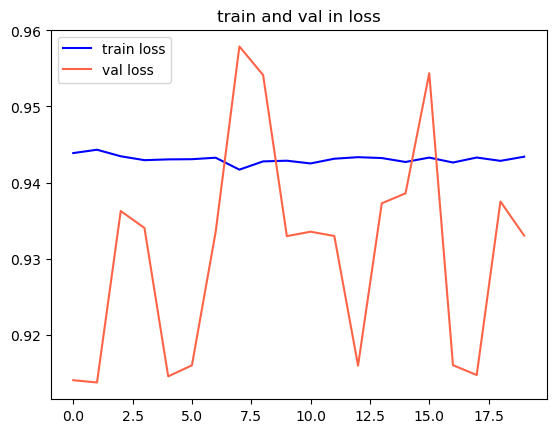

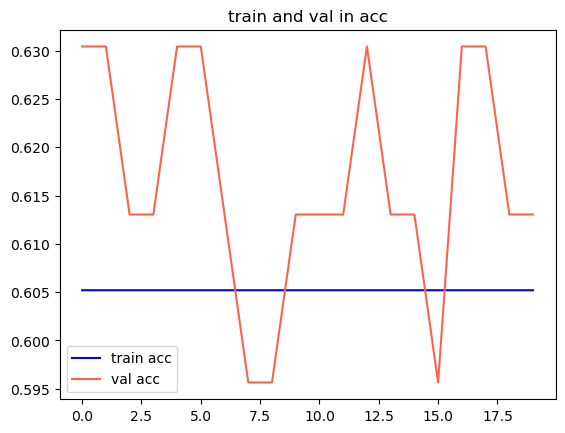

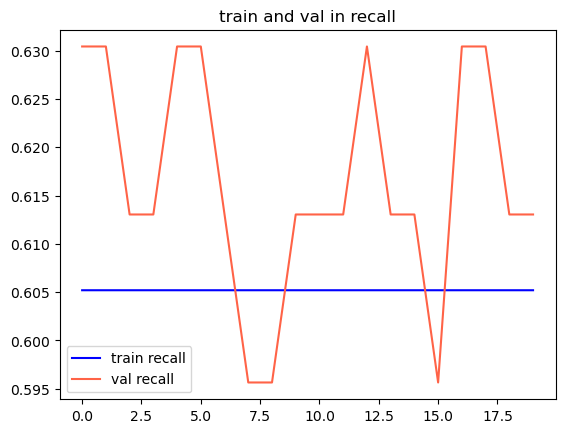

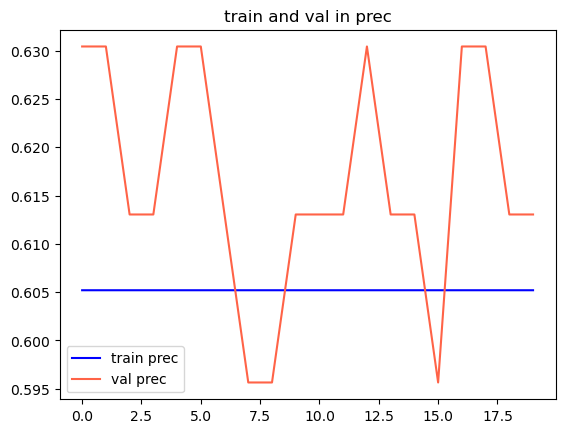

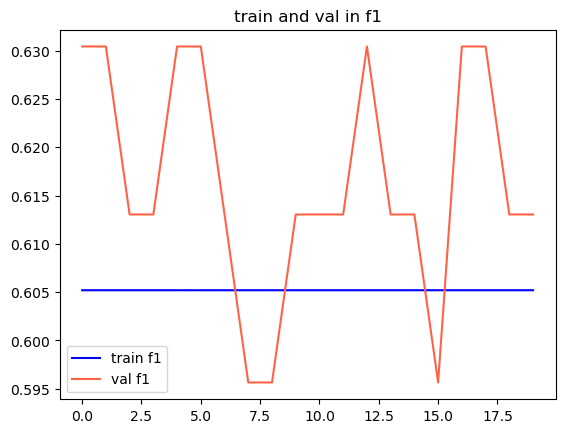

In [88]:
list2 = list(train_2.keys())
for i in list1:
    plt.plot(train_2[i], color='b',label='train '+i)
    plt.plot(val_2[i], color='tomato',label='val '+i)
    plt.title('train and val in '+i)
    plt.legend()
    plt.show()

In [89]:
# from rembg import remove
# from PIL import Image
# 
# 
# for i in range(len(all_mushrooms)):
#     for j in all_mushrooms[i]:
#         # 모든 이미지파일 이름 지정 완료
#         folder_path = os.path.join('./mushroom',name_List[i])
#         file_name = os.path.join(folder_path,j)
#         # 이미지 불러오기
#         img = Image.open(file_name)
#         
#         # 배경 제거하기
#         out = remove(img)
#         
#         # 변경된 이미지 저장
#         
#         folder_path2 = os.path.join('./mushroom2',name_List[i])
#         file_name2 = os.path.join(folder_path2,j)
#         if not os.path.exists(folder_path2): os.makedirs(folder_path2)
#         out.save(file_name2)

In [107]:
def classify_model_img(model_name, file_name):
    img = cv2.imread(file_name, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (150,150))
    
    plt.imshow(img)
    
    feature_img=img.reshape(-1)
    norm_img=feature_img/255.
    
    model = torch.load(model_name)
    
    input_img = torch.FloatTensor(norm_img)
    
    
    print(f'{model_name}으로 분류결과 : {m_list[model(input_img).argmax()]}')

In [97]:
def input_classify_model_img():
    model_name = input('사용할 모델을 입력하세요(끝까지): ')
    file_name = input('이미지 이름을 입력하세요(끝까지): ')
    img = cv2.imread(file_name, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (150,150))
    
    plt.imshow(img)
    
    feature_img=img.reshape(-1)
    norm_img=feature_img/255.
    
    model = torch.load(model_name)
    
    input_img = torch.FloatTensor(norm_img)
    
    print(m_list[model(input_img).argmax()])

edible


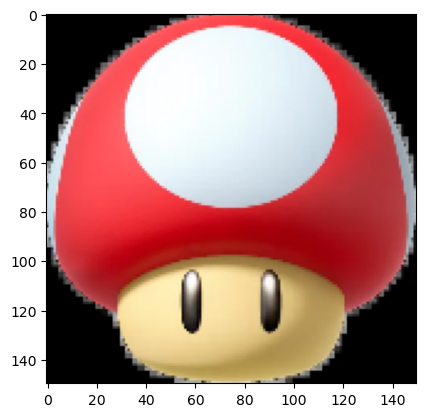

In [95]:
input_classify_model_img()

edible


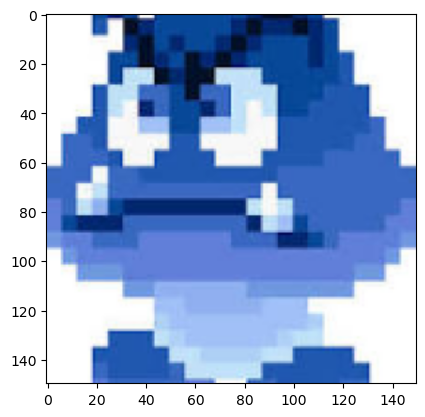

In [102]:
classify_model_img('new_mushroom_model.pth','test4.jpg')

edible
edible
edible
edible


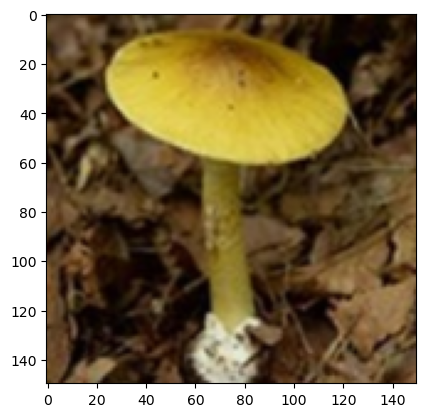

In [106]:
classify_model_img('new_mushroom_model.pth','yes2.png')
classify_model_img('mushroom_model.pth','yes2.png')
classify_model_img('mushroom_model2.pth','yes2.png')
classify_model_img('mushroom_model3.pth','yes2.png')

In [108]:
def all_model_make_mushroom(img_name):
    classify_model_img('new_mushroom_model.pth',img_name)
    classify_model_img('mushroom_model.pth',img_name)
    classify_model_img('mushroom_model2.pth',img_name)
    classify_model_img('mushroom_model3.pth',img_name)

new_mushroom_model.pth으로 분류결과 : edible
mushroom_model.pth으로 분류결과 : edible
mushroom_model2.pth으로 분류결과 : edible
mushroom_model3.pth으로 분류결과 : edible


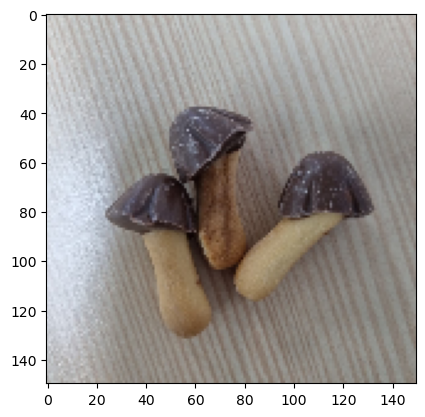

In [109]:
all_model_make_mushroom('test1.jpg')

new_mushroom_model.pth으로 분류결과 : edible
mushroom_model.pth으로 분류결과 : edible
mushroom_model2.pth으로 분류결과 : edible
mushroom_model3.pth으로 분류결과 : edible


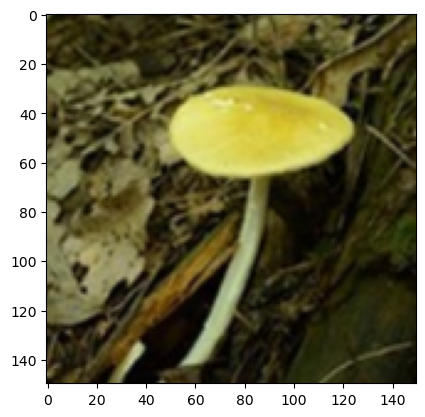

In [113]:
all_model_make_mushroom('yes1.png')

new_mushroom_model.pth으로 분류결과 : edible
mushroom_model.pth으로 분류결과 : edible
mushroom_model2.pth으로 분류결과 : edible
mushroom_model3.pth으로 분류결과 : edible


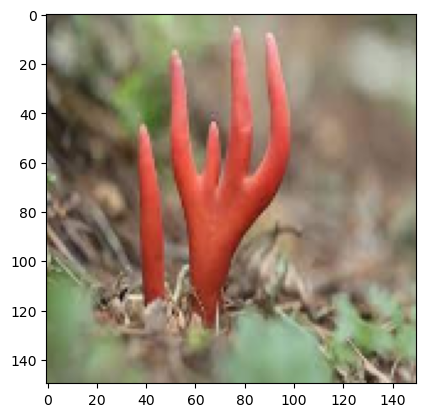

In [114]:
all_model_make_mushroom('test5.jpg')

new_mushroom_model.pth으로 분류결과 : edible
mushroom_model.pth으로 분류결과 : edible
mushroom_model2.pth으로 분류결과 : edible
mushroom_model3.pth으로 분류결과 : edible


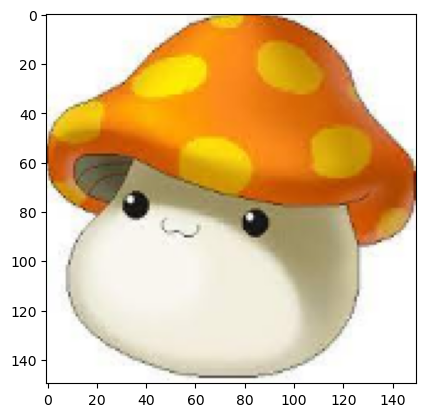

In [115]:
all_model_make_mushroom('test6.jpg')

new_mushroom_model.pth으로 분류결과 : edible
mushroom_model.pth으로 분류결과 : edible
mushroom_model2.pth으로 분류결과 : edible
mushroom_model3.pth으로 분류결과 : edible


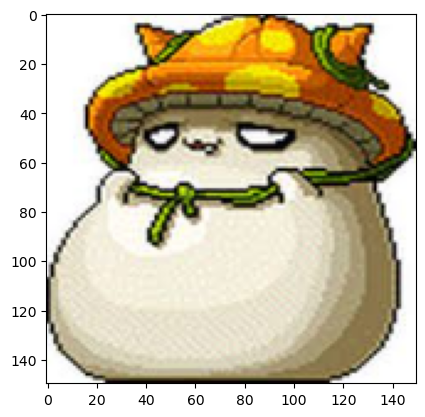

In [116]:
all_model_make_mushroom('test7.jpg')